In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, pickle
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import bptt_rnn as bp  # RNN, learning algorithm, loss function etc
import plot_routines as pr  # plotting functions & directly related
import rot_utilities as ru  # random utilies

%load_ext autoreload
%autoreload 2

In [2]:
single_time_labels = ['0', 'A', '0', 'B', '0', 'C', '0', 'D', '0']
double_time_labels = []
double_time_labels_half = []
for stl in single_time_labels:
    double_time_labels.append(stl)
    double_time_labels.append(stl)
    double_time_labels_half.append(stl)
    double_time_labels_half.append('')
double_time_labels_blank = [x.replace('0', '') for x in double_time_labels]
assert len(double_time_labels_half) == len(double_time_labels)

##  Task design

Trials consist of a sequence: 

$ A_{\alpha} \to B_{\alpha} \to C_{\beta} \to D$, where $\alpha, \beta \in (1, 2)$

Stimuli are interleaved with blanks $0$; e.g. $seq = (z_0, z_1, z_2, ... , z_8) = ( 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 )$
Sequences can either be _expected_: $\alpha = \beta$ (the majority of trials) or _unexpected_ $\alpha \neq \beta$ (remainder or trials).

We train a neural network to predict the next stimulus $z_{t+1}$ given the current stimulus $z_t$.

## Create synthetic data
There are 8 possible values: 
- 0 $blank/0$
- 1 $A_1$
- 2 $A_2$
- 3 $B_1$
- 4 $B_2$
- 5 $C_1$
- 6 $C_2$
- 7 $D$

Data points are thus 8-dim vectors, with:

$z_{k, t} = (1_{0}, 1_{A_1}, 1_{A_2}, ... , 1_{D})$

where $k$ is the trial index, and $t$ is the trial time. Hence $|z_{k, t}| = 1 $ before white noise is added. The goal of the task is to predict $z_{k, t+1}$ given its own state and $z_{k, t}$.

Trials will be either $T=9$ data points long (single), and of form:

$ 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 $

or of length $T=18$ (double), and of form:

$ 0, 0, A_{\alpha}, A_{\alpha}, 0, 0, B_{\alpha}, B_{\alpha}, 0, 0, C_{\beta}, C_{\beta}, 0, 0, D, D, 0, 0 $

where $\alpha, \beta \in (1, 2)$, although one can use shorter sequences for testing (e.g. $0, A_{\alpha}, 0, B_{\alpha}, 0$). The expected sequence is $\alpha = \beta$, and the unexpected sequence is $\alpha \neq \beta$.

Network input $x_k = z_{k, 0:T-1}$ and output $y_k = z_{k, 1:T}$. 

In [3]:
d_dict = {  # data parameters dictionary
        'n_total': 1000,  # total number of data sequences
        'n_freq': 8,  # blank through D
        'n_times': 9,
        'doublesse': True,
        'ratio_train': 0.8,
        'ratio_exp': 0.6,  # probabilities of switching between alpha nd beta
        'noise_scale': 0.15
        }
if d_dict['doublesse']:
    eval_times = np.arange(4, 17)  # double
    d_dict['sequence'] = np.array(double_time_labels)
elif d_dict['doublesse'] is False:
    eval_times = np.arange(1, 8)  # single
    d_dict['sequence'] = np.array(single_time_labels)
t_dict = {'eval_times': eval_times}  # training paramter dictionary

freq_labels = ['0', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D']
tmp0, tmp1 = bp.generate_synt_data(n_total=d_dict['n_total'], 
                                   n_times=d_dict['n_times'], 
                                   n_freq=d_dict['n_freq'],
                                   ratio_train=d_dict['ratio_train'], 
                                   ratio_exp=d_dict['ratio_exp'], 
                                   noise_scale=d_dict['noise_scale'], 
                                   double_length=d_dict['doublesse'])
x_train, y_train, x_test, y_test = tmp0
labels_train, labels_test = tmp1

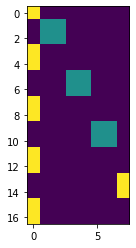

In [4]:
# x_train[:, :, 0] = 0
# x_test[:, :, 0] = 0
# y_train[:, :, 0] = 0
# y_test[:, :, 0] = 0
plt.imshow(y_train.mean(0))

## RNN Model with BPTT

#### RNN model:

$(x_t, s_{t-1}) \to s_t \to \hat{y}_t == y_t = x_{t+1} $

within one trial $k$. 
Equations:

$s_t = \tanh( U \cdot x_t + W \cdot s_{t-1})$


$\hat{y}_t = softmax(V \cdot s_t) = \left( \frac{e^{V_i \cdot s_t}}{\sum_i e^{V_i \cdot s_t}} \right), \; for \; i \in (0, A_1, A_2 ... D)$

where $U_{n x f}, W_{n x n}, V_{f x n}$ are matrices where $n$ is the number of RNN nodes and $f$ the number of input/output frequencies.

#### Training procedure:

The full sequence $x_k$ is forwarded through the model, yielding $\hat{y}_k$. This is used to compute the loss function $L$, which error is backpropagated through time (BPTT) to the parameters $\theta = (U, W, V)$ (updated with SGD probably). 
The loss function $L$ uses cross entropy and L1 regularisation:

$L_k = \sum_{\tau} - y_{k, \tau} \log \hat{y}_{k, \tau} + \lambda \cdot ||\theta||_1$

where $\tau$ defines the trial times that are taken into account for Loss computation. We set $\tau$ to all trial times _after_ the $A_{\alpha}$ stimuli have occured.

<!-- $ \begin{equation}
    \tau =
    \begin{cases}
      (0, 1, 2, ... 8), & \text{all} \\
      (1, 3, 5, 7), & \text{non-blank (nb)}\\
      (3, 5, 7), & \text{non-initial nb (ninb)}
    \end{cases}
  \end{equation}$
-->
#### Initial conditions:

We initialise $s_0$ with random values drawn from $N(0, 0.1)$ (for each trial individually).


#### Pseudo-algorithm:

    for $it$ in epochs:
        for $k$ in trials:
            for $t$ in times:
                rnn.forward($x_t$)
            compute loss $L_k$
            update parameters with BPTT


In [5]:
## Set training parameters:
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
if d_dict['doublesse']:
    t_dict['learning_rate'] = 0.002  # algorithm lr
elif d_dict['doublesse'] is False:
    t_dict['learning_rate'] = 0.05
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 40  # training epochs
t_dict['l1_param'] = 5e-3  # L1 regularisation in loss function
t_dict['check_conv'] = False  # check for convergence (and abort if converged)
t_dict['conv_rel_tol'] = 5e-4  # assess convergence by relative difference between two epochs is smaller than this 


## Train one single model

In [188]:
## Initiate RNN model
rnn = bp.RNN(n_stim=d_dict['n_freq'], n_nodes=t_dict['n_nodes'])  # Create RNN class
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
rnn.set_info(param_dict={**d_dict, **t_dict})

In [189]:
## Train with BPTT
rnn = bp.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)



  0%|          | 0/40 [00:00<?, ?it/s]

Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

Initialising training; start at epoch 0:   2%|▎         | 1/40 [00:04<03:07,  4.80s/it]

Epoch 1/40. Train loss: 8.589893:   2%|▎         | 1/40 [00:04<03:07,  4.80s/it]       

Epoch 1/40. Train loss: 8.589893:   5%|▌         | 2/40 [00:09<03:05,  4.89s/it]

Epoch 2/40. Train loss: 4.404918:   5%|▌         | 2/40 [00:09<03:05,  4.89s/it]

Epoch 2/40. Train loss: 4.404918:   8%|▊         | 3/40 [00:15<03:13,  5.22s/it]

Epoch 3/40. Train loss: 2.829237:   8%|▊         | 3/40 [00:19<04:02,  6.57s/it]

Training ended prematurely by user at epoch 3.
Results saved in RNN Class.


In [24]:
# rnn.save_model()
float(rnn.test_loss_ratio_ce[0].detach().numpy())

0.9260377883911133

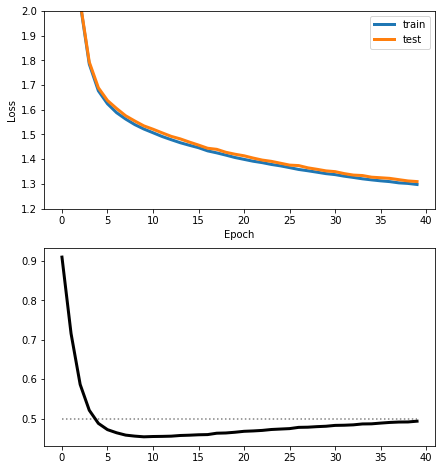

In [8]:
## Plot train/test loss during training
plt.rcParams['figure.figsize'] = (7, 8)
# plt.subplot(211)
ax_conv = pr.plot_train_test_perf(rnn_model=rnn, ax=plt.subplot(211))
plt.ylim([1.2, 2])

plt.subplot(212)
plt.plot(np.arange(rnn.info_dict['trained_epochs']), 
         np.zeros_like(rnn.test_loss_ratio_ce) + 0.5, c='grey', linestyle=':')
plt.plot(rnn.test_loss_ratio_ce, linewidth=3, c='k')


In [9]:
print(labels_test)

['21' '11' '22' '11' '22' '22' '22' '22' '22' '21' '22' '22' '11' '22'
 '12' '11' '11' '22' '11' '11' '11' '22' '22' '12' '22' '11' '11' '22'
 '22' '22' '11' '22' '11' '22' '21' '22' '11' '11' '11' '11' '11' '22'
 '11' '22' '11' '11' '12' '22' '22' '21' '21' '11' '11' '12' '22' '22'
 '21' '12' '12' '22' '21' '12' '12' '22' '11' '11' '22' '11' '22' '21'
 '22' '22' '11' '22' '12' '11' '22' '12' '11' '11' '22' '11' '11' '22'
 '22' '11' '11' '22' '11' '11' '12' '22' '12' '22' '21' '11' '22' '22'
 '11' '11' '22' '21' '22' '22' '21' '22' '11' '22' '11' '11' '11' '22'
 '11' '12' '11' '11' '22' '12' '22' '11' '11' '22' '21' '11' '12' '11'
 '12' '11' '21' '22' '12' '11' '11' '22' '11' '12' '22' '11' '22' '11'
 '22' '22' '12' '11' '21' '11' '11' '11' '21' '12' '11' '22' '11' '22'
 '11' '22' '21' '22' '22' '22' '22' '11' '22' '22' '21' '22' '12' '11'
 '22' '22' '11' '11' '21' '22' '11' '21' '11' '12' '11' '22' '22' '11'
 '21' '21' '21' '11' '12' '22' '11' '11' '21' '21' '12' '22' '21' '11'
 '22' 

torch.Size([17, 8])


(8.0, 0.0)

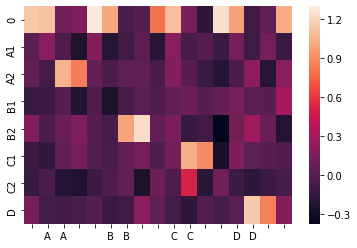

In [10]:
plt.rcParams['figure.figsize'] = (6, 4)
k = 0
print(x_test[k, :, :].shape)
# x_test[k, np.array([2, 3]), 1] = 0
# x_test[k, np.array([2, 3]), 7] = 1
# x_test[k, np.array([6, 7]), 3] = 0
# x_test[k, np.array([6, 7]), 7] = 0
ax_true_w = sns.heatmap(x_test[k, :, :].T, yticklabels=freq_labels,
            xticklabels=double_time_labels_blank[1:])
bottom, top = ax_true_w.get_ylim()
ax_true_w.set_ylim(bottom + 0.5, top - 0.5)

Trial type: ['12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12'
 '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12']


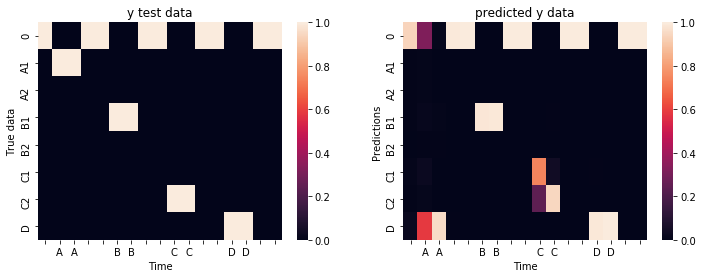

In [11]:
## Plot example test sample & prediction
k = np.where(labels_test == '12')[0]
print(f'Trial type: {labels_test[k]}')
pred = bp.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions
plt.rcParams['figure.figsize'] = (12, 4)

plt.subplot(121)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
ax_true_w = sns.heatmap(true_data.numpy().T, yticklabels=freq_labels,
            xticklabels=double_time_labels_blank[1:])
bottom, top = ax_true_w.get_ylim()
ax_true_w.set_ylim(bottom + 0.5, top - 0.5)
plt.title("y test data"); plt.xlabel('Time'); plt.ylabel('True data')

plt.subplot(122)
ax_pred = sns.heatmap(pred.mean(0).detach().numpy().T, vmax=1, vmin=0, yticklabels=freq_labels,
           xticklabels=double_time_labels_blank[1:])  # average if multiple samples
bottom, top = ax_pred.get_ylim()
ax_pred.set_ylim(bottom + 0.5, top - 0.5)
plt.title("predicted y data"); plt.xlabel('Time'); plt.ylabel("Predictions");

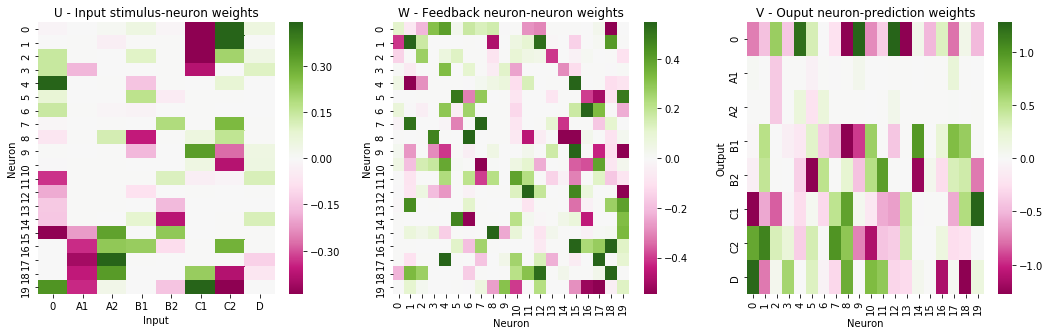

In [12]:
## Plot weight matrices U, W, V
plt.rcParams['figure.figsize'] = (18, 5)
w_order = pr.opt_leaf(w_mat=rnn.lin_input, dim=0)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels, weight_order=w_order)

## Cross temporal decoding

Each sequence $seq_k$ has labels $\alpha, \beta$. We wish to decode $\alpha$ dynamically per time point, in a cross-temporal manner, from the RNN hidden state $s_t$. Id est, we will create a decoder $dec(t | \tau) = P(\alpha = 1 | \tau)_t$ that is trained at time $\tau$ but evaluated at time $t$. We can choose to train our decoder with either or both $(\alpha = \beta)$ and $(\alpha \neq \beta)$ sequences. To decode, we will use a linear SVM with L2 regularisation (from sklearn). 

#### Pseudocode

    forward run of all trials
    for $\tau$ in T:
        train P($\alpha$ | $\tau$)
        for t in T:
            evaluate P($\alpha$ | $\tau$)_t

In [14]:
score_mat, decoder_dict = bp.train_decoder(rnn_model=rnn, x_train=x_train, x_test=x_test,
                                           labels_train=labels_train, labels_test=labels_test)

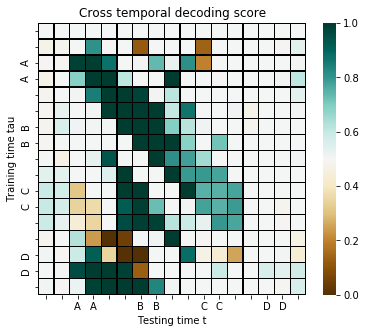

In [15]:
# score_mat[0, 5] = -10
plt.rcParams['figure.figsize'] = (6, 5)
ax_score = pr.plot_decoder_crosstemp_perf(score_matrix=score_mat, ax=plt.subplot(111),
                               ticklabels=double_time_labels_blank[:-1])

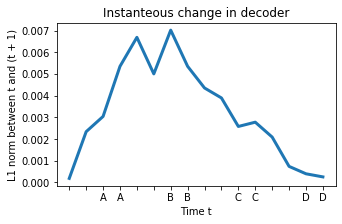

In [16]:
angle_change = np.zeros(x_train.shape[1] - 1)
for tau in range(x_train.shape[1] - 1):
    angle_change[tau] = np.sum(np.abs(decoder_dict[tau].coef_ - decoder_dict[tau + 1].coef_))
    
plt.rcParams['figure.figsize'] = (5, 3)
f, ax_ac = plt.subplots(1, 1)
ax_ac.plot(angle_change, linewidth=3)
ax_ac.set_xlabel('Time t'); ax_ac.set_ylabel('L1 norm between t and (t + 1)')
ax_ac.set_title('Instanteous change in decoder')
ax_ac.set_xticks(np.arange(len(angle_change)));
ax_ac.set_xticklabels(double_time_labels_blank[:-2]);

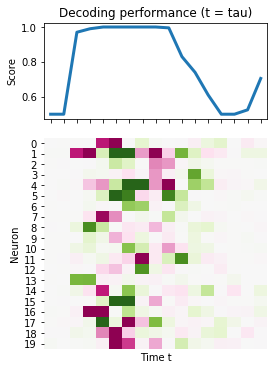

In [57]:
plt.rcParams['figure.figsize'] = (4, 6)
_, __ = pr.plot_dynamic_decoding_axes(rnn=rnn)

## Train & save multiple models

In [ ]:
## Train a lot of models for saving:
_ = bp.init_train_save_rnn(t_dict=t_dict, d_dict=d_dict, 
                           n_simulations=51, save_folder='models/60-40_49models/')

Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]


-----------
simulation 0/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0739.data

-----------
simulation 1/51


Epoch 39/40. Train loss: 1.405012: 100%|██████████| 40/40 [03:27<00:00,  5.18s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0742.data

-----------
simulation 2/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0746.data

-----------
simulation 3/51


Epoch 39/40. Train loss: 1.427706: 100%|██████████| 40/40 [03:37<00:00,  5.44s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0749.data

-----------
simulation 4/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0753.data

-----------
simulation 5/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0757.data

-----------
simulation 6/51


Epoch 39/40. Train loss: 1.408864: 100%|██████████| 40/40 [03:34<00:00,  5.36s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0800.data

-----------
simulation 7/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0805.data

-----------
simulation 8/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0812.data

-----------
simulation 9/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0820.data

-----------
simulation 10/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0827.data

-----------
simulation 11/51


Epoch 39/40. Train loss: 1.441966: 100%|██████████| 40/40 [07:23<00:00, 11.08s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0834.data

-----------
simulation 12/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0842.data

-----------
simulation 13/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0849.data

-----------
simulation 14/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0855.data

-----------
simulation 15/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0900.data

-----------
simulation 16/51


Epoch 39/40. Train loss: 1.422421: 100%|██████████| 40/40 [04:36<00:00,  6.90s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0905.data

-----------
simulation 17/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0909.data

-----------
simulation 18/51


Epoch 39/40. Train loss: 1.397473: 100%|██████████| 40/40 [03:47<00:00,  5.68s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0913.data

-----------
simulation 19/51


Epoch 39/40. Train loss: 1.461762: 100%|██████████| 40/40 [03:48<00:00,  5.71s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0916.data

-----------
simulation 20/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0920.data

-----------
simulation 21/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0925.data

-----------
simulation 22/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0928.data

-----------
simulation 23/51


Epoch 39/40. Train loss: 1.423349: 100%|██████████| 40/40 [04:23<00:00,  6.58s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0933.data

-----------
simulation 24/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0937.data

-----------
simulation 25/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0941.data

-----------
simulation 26/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0946.data

-----------
simulation 27/51


Epoch 39/40. Train loss: 1.434523: 100%|██████████| 40/40 [04:25<00:00,  6.63s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0950.data

-----------
simulation 28/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0955.data

-----------
simulation 29/51


Epoch 39/40. Train loss: 1.41931: 100%|██████████| 40/40 [04:21<00:00,  6.53s/it]      
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-0959.data

-----------
simulation 30/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1004.data

-----------
simulation 31/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1008.data

-----------
simulation 32/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1012.data

-----------
simulation 33/51


Epoch 39/40. Train loss: 1.458394: 100%|██████████| 40/40 [03:43<00:00,  5.58s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1015.data

-----------
simulation 34/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1019.data

-----------
simulation 35/51


Epoch 39/40. Train loss: 1.426031: 100%|██████████| 40/40 [03:43<00:00,  5.59s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1023.data

-----------
simulation 36/51


Epoch 39/40. Train loss: 1.459114: 100%|██████████| 40/40 [03:39<00:00,  5.48s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1027.data

-----------
simulation 37/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1030.data

-----------
simulation 38/51


Epoch 39/40. Train loss: 1.473343: 100%|██████████| 40/40 [03:30<00:00,  5.26s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1034.data

-----------
simulation 39/51


Epoch 39/40. Train loss: 1.417741: 100%|██████████| 40/40 [03:37<00:00,  5.43s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1038.data

-----------
simulation 40/51


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-15-1041.data

-----------
simulation 41/51


Epoch 16/40. Train loss: 1.580838:  40%|████      | 16/40 [01:24<02:07,  5.30s/it]     

In [15]:
## Retrain decoders:
_ = bp.train_multiple_decoders(rnn_folder='models/75-25_100models/', n_samples=1000)

0it [00:00, ?it/s]

train labels  {'11': 200, '12': 200, '21': 200, '22': 200}


3it [00:05,  1.79s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
7it [00:13,  1.93s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
9it [00:17,  2.07s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
11it [00:22,  2.15s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/t

68it [02:40,  2.22s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
70it [02:45,  2.31s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
72it [02:49,  2.31s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
73it [02:52,  2.27s/it]/hom

In [16]:
agg_conv, agg_score, agg_decoder_mat, agg_weights = {}, {}, {}, {}
folder_dict = {50: 'models/50-50_44models/', 75: 'models/75-25_100models/',
               90: 'models/90-10_100models/', 60: 'models/60-40_49models/',
               100:'models/100-0_56models/'}
folder_dict = {kk: folder_dict[kk] for kk in np.sort(list(folder_dict.keys()))}
for kk, vv in folder_dict.items():
    agg_conv[kk] = bp.aggregate_convergence(model_folder=vv)
    agg_score[kk] = bp.aggregate_score_mats(model_folder=vv)
    agg_decoder_mat[kk] = bp.aggregate_decoders(model_folder=vv)
    agg_weights[kk] = bp.aggregate_weights(model_folder=vv, weight='U')

<Figure size 720x1296 with 0 Axes>

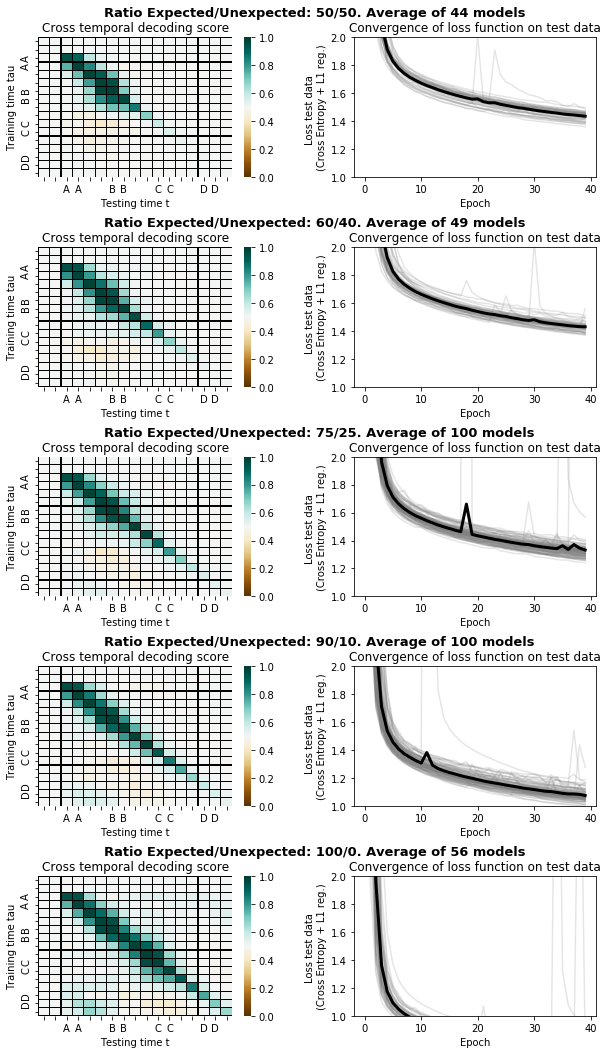

In [17]:
plt.rcParams['figure.figsize'] = (10, 18)
plt.subplots_adjust(hspace=0.6)
fig, ax_agg = plt.subplots(len(folder_dict), 2)
for i_ax, kk in enumerate(list(agg_conv.keys())):
    model_selection = np.arange(agg_score[kk].shape[0])
#     model_selection = agg_score[kk][:, 11, 6] < 0.4
#     plot_mat = np.mean(np.abs(agg_score[kk][model_selection, :, :] - 0.5) + 0.5, 0)
    plot_mat = np.mean(agg_score[kk][model_selection, :, :], 0)
    pr.plot_decoder_crosstemp_perf(score_matrix=plot_mat, 
                                   ax=ax_agg[i_ax][0], ticklabels=double_time_labels_blank[:-1])

    ax_agg[i_ax][1].plot(agg_conv[kk]['test'][:100, :].T, alpha=0.2, c='grey')
    ax_agg[i_ax][1].plot(np.mean(agg_conv[kk]['test'], 0), linewidth=3, c='k')
    ax_agg[i_ax][1].set_ylim([1, 2]); 
    ax_agg[i_ax][1].set_ylabel('Loss test data \n(Cross Entropy + L1 reg.)')
    ax_agg[i_ax][1].set_xlabel('Epoch'); ax_agg[i_ax][1].set_title('Convergence of loss function on test data');
    ax_agg[i_ax][1].text(s=f'Ratio Expected/Unexpected: {kk}/{100 - kk}. Average of {agg_score[kk].shape[0]} models',
                         x=-46, y=2.15, fontdict={'weight': 'bold', 'fontsize': 13})
fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig('results/average_results_new.pdf', bbox_inches='tight')

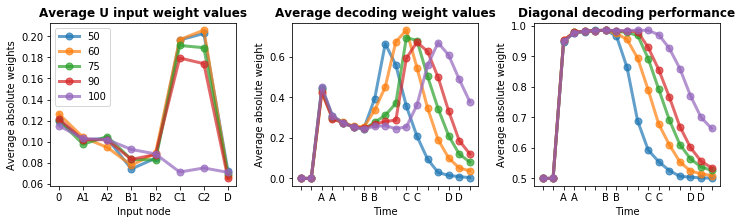

In [18]:
plt.rcParams['figure.figsize'] = (12, 3)
plt.subplots_adjust(wspace=0.3)

ax_abs_w = plt.subplot(131)
for kk in agg_weights.keys():
    ax_abs_w.plot(np.mean(agg_weights[kk], 0), alpha=0.7,
                  marker='.', linewidth=3, markersize=14, label=kk)
#     ax_abs_w.bar(x=freq_labels, height=np.mean(agg_weights[kk], 0))
plt.legend(); ax_abs_w.set_xticks(np.arange(agg_weights[kk].shape[1]));
ax_abs_w.set_xticklabels(freq_labels); ax_abs_w.set_ylabel('Average absolute weights')
ax_abs_w.set_title('Average U input weight values', weight='bold')
ax_abs_w.set_xlabel('Input node')
ax_dec_w = plt.subplot(132)
for kk in agg_decoder_mat.keys():
    ax_dec_w.plot(np.abs(agg_decoder_mat[kk]).mean((0, 1)),alpha=0.7,
                  marker='.', linewidth=3, markersize=14, label=kk)
ax_dec_w.set_xticks(np.arange(agg_decoder_mat[75].shape[2]))
ax_dec_w.set_xticklabels(double_time_labels_blank[:-1]);
ax_dec_w.set_xlabel('Time'); ax_dec_w.set_ylabel('Average absolute weight');
ax_dec_w.set_title('Average decoding weight values', weight='bold')

ax_dec_w = plt.subplot(133)
for kk in agg_decoder_mat.keys():
    ax_dec_w.plot(np.diag(agg_score[kk].mean(0)), alpha=0.7,
                  marker='.', linewidth=3, markersize=14, label=kk)
ax_dec_w.set_xticks(np.arange(agg_decoder_mat[75].shape[2]))
ax_dec_w.set_xticklabels(double_time_labels_blank[:-1]);
ax_dec_w.set_xlabel('Time'); ax_dec_w.set_ylabel('Average absolute weight');
ax_dec_w.set_title('Diagonal decoding performance', weight='bold');


In [33]:
for ii, ll in enumerate(double_time_labels_blank[:-1]):
    print(ii, ll)

0 
1 
2 A
3 A
4 
5 
6 B
7 B
8 
9 
10 C
11 C
12 
13 
14 D
15 D
16 


Mean: 0.43


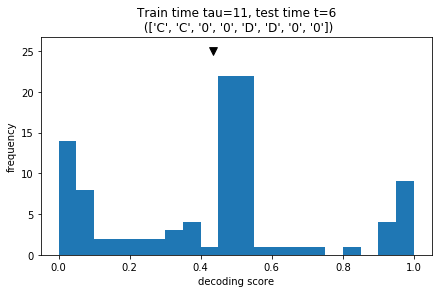

In [34]:
plt.rcParams['figure.figsize'] = (7, 4)
train_time = 11
test_time = 6
hist_arr = agg_score[90][:, train_time, test_time]
plt.hist(hist_arr, bins=np.linspace(0, 1, 21));
plt.scatter(np.mean(hist_arr), 25, marker='v', color='k', s=60)
print(f'Mean: {np.round(np.mean(hist_arr), 2)}')
plt.xlabel('decoding score'); plt.ylabel('frequency'); 
plt.title(f'Train time tau={train_time}, test time t={test_time}\n ({double_time_labels[train_time-1:]})');

In [55]:
rnn_folder = 'models/7525_100models/'
inds_selection = np.where(agg_score[75][:, train_time, test_time] > 0.4)[0]
list_rnns = [x for x in os.listdir(rnn_folder) if x[-5:] == '.data']
rnn_name = list_rnns[inds_selection[2]]
# rnn_name = 'rnn_2020-05-11-1501.data'
with open(rnn_folder + rnn_name, 'rb') as f:
    rnn = pickle.load(f)
print(rnn.decoding_crosstemp_score[train_time, test_time])

0.512905299738551


In [75]:
# import importlib
# importlib.reload(bp)
_, __  = bp.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5)

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [76]:
# rnn.decoding_crosstemp_score[0, 10:12] = 2

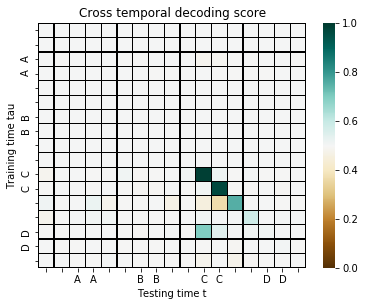

In [77]:
plt.rcParams['figure.figsize'] = (6, 4.5)
pr.plot_decoder_crosstemp_perf(score_matrix=rnn.decoding_crosstemp_score, 
                               ax=plt.subplot(111), 
                               ticklabels=double_time_labels_blank[:-1])


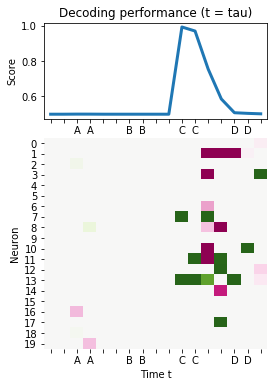

In [78]:
plt.rcParams['figure.figsize'] = (4, 6)
_, __ = pr.plot_dynamic_decoding_axes(rnn=rnn, ticklabels=double_time_labels_blank[:-1])

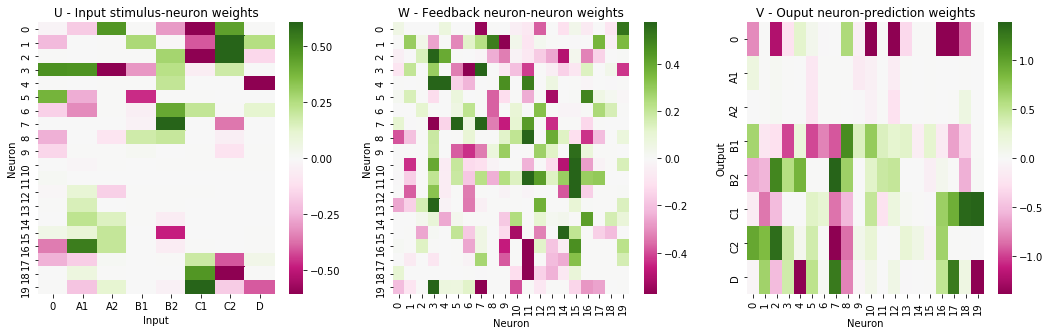

In [64]:

plt.rcParams['figure.figsize'] = (18, 5)
w_order = pr.opt_leaf(w_mat=rnn.lin_input, dim=0)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels, weight_order=w_order)